In [125]:
import requests
import json
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Part A: Download the Zelda Wikipages of characters¶

In [126]:
baseurl = "https://zelda.fandom.com/api.php?"
action = "action=query"
title = "titles=Characters in Breath of the Wild|Enemies in Breath of the Wild|Bosses in Breath of the Wild"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
print(query)

https://zelda.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=Characters in Breath of the Wild|Enemies in Breath of the Wild|Bosses in Breath of the Wild&format=json


In [127]:
response = requests.get(query)
wikitext = response.json()
with open('zelda-characters.json', 'w') as f:
  json.dump(wikitext, f)

In [128]:
with open('zelda-characters.json', 'r') as f:
  data=f.read()

wikitext = json.loads(data)

In [129]:
df = pd.DataFrame()

for key, value in wikitext["query"]["pages"].items():
  character_type = value["title"].split(" ")[0]
  raw_text = value["revisions"][0]["slots"]["main"]["*"]

  if character_type == "Enemies": # Truncate to remove trap portion of enemies
    raw_text = raw_text.split("Traps")[0]

  matches = re.findall(r'(?<!\(){{\w*\|BotW\|([^|]*)\|link}}(?!\))', raw_text) # Here we use negative lookbehind/lookahed to ensure we don't match the location links

  for match in matches:
    df = df.append({"Type": character_type, "Name": match}, ignore_index=True)




In [130]:
df.replace(to_replace=["Characters", "Bosses", "Enemies"], value=["Ally", "Boss", "Enemy"], inplace=True)

In [131]:
df.Type.value_counts()

Ally     573
Enemy     72
Boss      25
Name: Type, dtype: int64

In [132]:
df.drop_duplicates(inplace=True) # Here we drop trivial duplicates

In [133]:
dupes = df.duplicated(subset="Name")

In [134]:
dupes = df.pivot_table(index=["Name"], aggfunc='size')
dupes[dupes > 1]

Name
Calamity Ganon    2
Master Kohga      2
dtype: int64

In [135]:
df2 = df[df["Name"].isin(dupes[dupes > 1].index)]
df2

,Type,Name
21,Boss,Master Kohga
23,Boss,Calamity Ganon
140,Ally,Calamity Ganon
365,Ally,Master Kohga


The non trivial duplicates are where the same character is listed as both and Ally, as well as a Boss. We choose the Boss classification to be carry more meaning and will therefore drop the duplicates listed as allies

In [136]:
i = df[((df.Type == 'Ally') & (df.Name == "Calamity Ganon"))].index
i2 = df[((df.Type == 'Ally') & (df.Name == "Master Kohga"))].index
df = df.drop(i)
df = df.drop(i2)

In [137]:
i = df[(df.Name == "Enemy")].index
df = df.drop(i)

In [138]:
df.to_csv('zelda-characters.csv', index=False)

Save all character pages in txt files:

In [139]:
baseurl = "https://zelda.fandom.com/api.php?"
action = "action=query"
title = "titles=Stone_Talus_(Junior)"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
print(query)

https://zelda.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=Stone_Talus_(Junior)&format=json


In [140]:
characters = pd.read_csv("zelda-characters.csv")

In [141]:
aliases = {}

for name in characters.Name:
  formatted_name = name.replace(" ", "_")
  title = "titles=" + formatted_name
  query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
  response = requests.get(query)
  wikitext = response.json()

  redirects = re.search(r"#REDIRECT\s\[\[(.*)\]\]", str(wikitext))
  if redirects:

    # Update dictionary containing aliases (redirects)
    aliases[name] = redirects.group(1)

    # Fetch correct page for redirected character
    formatted_name = redirects.group(1).replace(" ", "_")
    title = "titles=" + formatted_name
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    response = requests.get(query)
    wikitext = response.json()

  # Filter response to store only relevant content
  text = list(wikitext["query"]["pages"].items())[0][1]["revisions"][0]["slots"]["main"]["*"]

  # Write characters wiki page contents to file
  with open(f'characters/{formatted_name}.txt', 'w') as f:
    json.dump(text, f)

# Part B: Building the network

In [142]:
df_characters = pd.read_csv("zelda-characters.csv")
df_characters.head()

,Type,Name
0,Boss,Stone Talus
1,Boss,Stone Talus (Junior)
2,Boss,Stone Talus (Senior)
3,Boss,Stone Talus (Luminous)
4,Boss,Stone Talus (Rare)


In [143]:
pattern1 = r"\[\[(.*?)(?:\|.*?|#.*?)?\]\]"
pattern2 = r"\{\{(?:Plural|Term)\|BotW\|([^\}]*?)(?!\})(?:\|link(?:\|display=.*?)?\}\}|(?:\|display=[^\}]*?\|link)?\}\})"
link_pattern = pattern1+"|"+pattern2

gender_pattern = r"gender=\s(\w\w*?)(?:\\n|<)"
race_pattern = r"race= \{\{(?:Term|Plural)\|(?:BotW|Series)\|(.*?)\|(?:.*?)\}\}"

content_length_pattern = r"(\s\w+)"

In [144]:
pages_path = "characters/"

DG = nx.DiGraph()

# Create node for character, and create role attribute
for character in df_characters.Name.values:
  DG.add_node(character, role=list(df_characters.loc[df_characters["Name"] == character, 'Type'])[0])

for character in df_characters.Name.values:

  # Get wiki text for character
  if character in aliases:
    with open(pages_path+aliases[character].replace(" ","_")+".txt", "r") as f:
      text = f.read()
  else:
    with open(pages_path+character.replace(" ","_")+".txt", "r") as f:
      text = f.read()

  # Get and set remaining attributes of character
  gender = re.search(gender_pattern, text)
  if gender:
    DG.nodes[character]["gender"] = gender.group(1)
  else:
    DG.nodes[character]["gender"] = "Unknown"

  race = re.search(race_pattern, text)
  if race:
    DG.nodes[character]["race"] = race.group(1)
  else:
    DG.nodes[character]["race"] = "Unknown"

  words = re.findall(content_length_pattern, text)
  if text:
    DG.nodes[character]["content-length"] = len(words)
  else:
    DG.nodes[character]["content-length"] = 0

  # Create edges for links
  links1 = re.findall(pattern1, text)
  links2 = re.findall(pattern2, text)
  links = links1 + links2
  if links:
    for link in links:
      if link in aliases: # handling redirects
        link = aliases[link]
      if link in list(df_characters["Name"].values) and link != character:
        DG.add_edge(character, link)

In [145]:
print(len(DG.nodes()))
print(DG.number_of_edges())

df_characters

656
1618


,Type,Name
0,Boss,Stone Talus
1,Boss,Stone Talus (Junior)
2,Boss,Stone Talus (Senior)
3,Boss,Stone Talus (Luminous)
4,Boss,Stone Talus (Rare)
...,...,...
651,Enemy,Treasure Octorok
652,Enemy,Water Octorok
653,Enemy,White-Maned Lynel
654,Enemy,Yiga Blademaster


In [146]:
isolated_nodes = [node for node in DG.nodes if DG.out_degree(node) == 0 and DG.in_degree(node) == 0]
DG.remove_nodes_from(isolated_nodes)

In [147]:
print(len(DG.nodes()))
print(DG.number_of_edges())

540
1618


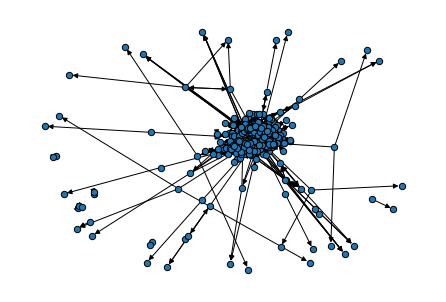

In [148]:
nx.draw(DG, node_size=40, edgecolors="black")

Exercise 2

In [149]:
print(len(DG.nodes))
print(len(DG.edges))

540
1618


<AxesSubplot:>

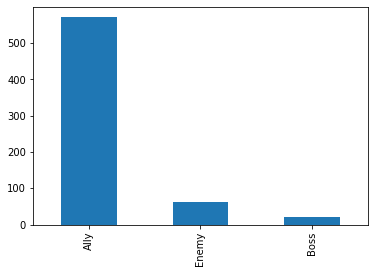

In [150]:
characters['Type'].value_counts().plot(kind='bar')

In [151]:

  # for character in DG.nodes.data():
  #   print(character)

# print(DG.nodes(data=True))
allies = [x for x,y in DG.nodes(data=True) if 'role' in y and y['role'] == "Ally"]
enemies = [x for x,y in DG.nodes(data=True) if 'role' in y and y['role'] == "Enemy"]
bosses = [x for x,y in DG.nodes(data=True) if 'role' in y and y['role'] == "Boss"]

males = [x for x,y in DG.nodes(data=True) if 'gender' in y and y['gender'] == "Male"]
females = [x for x,y in DG.nodes(data=True) if 'gender' in y and y['gender'] == "Female"]

races_pre = [(x,y) for x,y in DG.nodes(data=True) if 'race' in y]

races_pre


[('Stone Talus',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Unknown',
   'content-length': 546}),
 ('Stone Talus (Junior)',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Stone Talus',
   'content-length': 20}),
 ('Stone Talus (Senior)',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Stone Talus',
   'content-length': 20}),
 ('Stone Talus (Luminous)',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Stone Talus',
   'content-length': 178}),
 ('Stone Talus (Rare)',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Stone Talus',
   'content-length': 159}),
 ('Igneo Talus',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Unknown',
   'content-length': 296}),
 ('Frost Talus',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Unknown',
   'content-length': 183}),
 ('Hinox',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Unknown',
   'content-length': 2220}),
 ('Blue Hinox',
  {'role': 'Boss',
   'gender': 'Unknown',
   'race': 'Hino

In [152]:
def plot_degree_dist(G, in_degree=None, out_degree=None, bins=100):
    if in_degree:
        degrees = [G.in_degree(n) for n in G.nodes()]
    elif out_degree:
        degrees = [G.out_degree(n) for n in G.nodes()]
    else:
        degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins)
    plt.show()

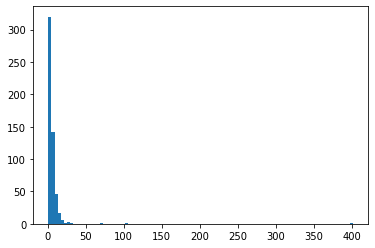

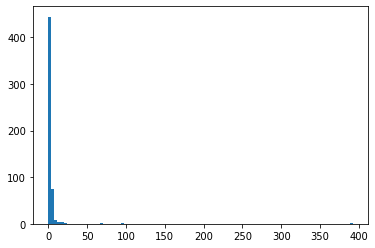

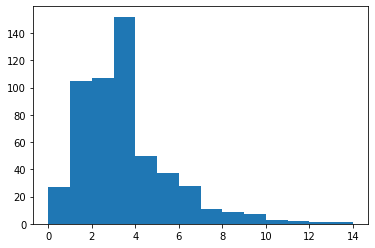

In [153]:
plot_degree_dist(DG)
plot_degree_dist(DG, in_degree=True)
plot_degree_dist(DG, out_degree=True, bins=14)

Something interesting to note regarding the degree distributions is the existence of a node that has considerably more in degrees than any other. This can be reasonably assumed to be for the characater Link. It would be expected that many character pages have links pointing to Link as he is the main character of the story.

It is also the case that there isn't the same outlier for out degree as no signle character links to so many others.

**Compare the degree distribution to a random network with the same number of nodes and p**

⟨k⟩=2⟨L⟩/N=p(N−1)

p = ⟨k⟩/(N-1)

In [154]:
len(DG.nodes())


540

In [155]:
import pickle
with open("../week4/character_graph", "wb") as f:
  pickle.dump(DG, f)

In [156]:
with open('../week4/character_graph', 'rb') as f:
  DG = pickle.load(f)

In [157]:
df = pd.DataFrame.from_dict(dict(DG.nodes(data=True)), orient='index')

In [158]:
N = len(DG.nodes)
L = len(DG.edges)
avg_degree = 2*L / N
p = avg_degree / (N-1)


In [159]:
G = nx.erdos_renyi_graph(N, p)

Text(0.5, 1.0, 'Erdös-Renyi degree distribution')

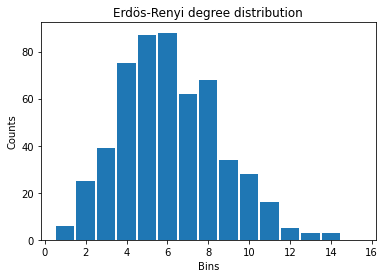

In [160]:
values_G = [ v for k,v in G.degree]
v = np.arange(min(values_G), max(values_G))
hist, bins = np.histogram(values_G, bins = v)
width = 0.9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2 - 0.5
plt.bar(center, hist, width=width)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Erdös-Renyi degree distribution')

In [161]:
SFG = nx.scale_free_graph(N)

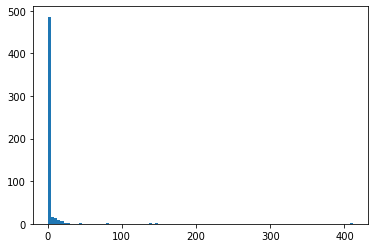

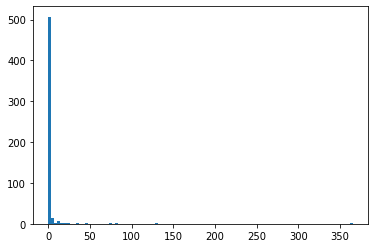

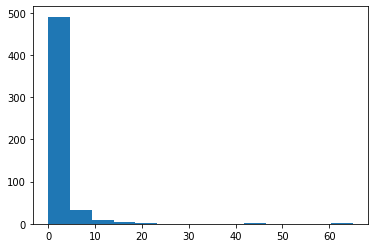

In [162]:
plot_degree_dist(SFG)
plot_degree_dist(SFG, in_degree=True)
plot_degree_dist(SFG, out_degree=True, bins=14)

In [163]:
df_characters

,Type,Name
0,Boss,Stone Talus
1,Boss,Stone Talus (Junior)
2,Boss,Stone Talus (Senior)
3,Boss,Stone Talus (Luminous)
4,Boss,Stone Talus (Rare)
...,...,...
651,Enemy,Treasure Octorok
652,Enemy,Water Octorok
653,Enemy,White-Maned Lynel
654,Enemy,Yiga Blademaster


In [164]:
DG.nodes

NodeView(('Stone Talus', 'Stone Talus (Junior)', 'Stone Talus (Senior)', 'Stone Talus (Luminous)', 'Stone Talus (Rare)', 'Igneo Talus', 'Frost Talus', 'Hinox', 'Blue Hinox', 'Black Hinox', 'Stalnox', 'Molduga', 'Igneo Talus Titan', 'Molduking', 'Windblight Ganon', 'Fireblight Ganon', 'Thunderblight Ganon', 'Waterblight Ganon', 'Master Kohga', 'Monk Maz Koshia', 'Calamity Ganon', 'Dark Beast Ganon', 'Baddek', 'Bamboo', 'Banji', 'Baumar', 'Bayge', 'Beedle', 'Bolson', 'Brigo', 'Cambo', 'Chabi', 'Chork', 'Chumin', 'Dabi', 'Daruk', 'Dauntless', 'Dinraal', 'Ena', 'Endai', 'Epona', 'Farosh', 'Fyson', 'Greyson', 'Heehl', 'Hestu', 'Hudson', 'Hylia', 'Kabetta', 'Kapson', 'Karson', 'Kass', 'Kenyo', 'Kilton', 'Link', 'Meghyn', 'Mei', 'Mils', 'Mina', 'Mipha', 'Misko', 'Nat', 'Naydra', 'Nazbi', 'Pelison', 'Pikango', 'Revali', 'Rhondson', 'Rik', 'Savelle', 'Sho', 'Spoone', 'Toren', 'Urbosa', 'Yammo', 'Princess Zelda', 'Zyle', 'Naddon', 'Pitar', 'Dmitri', 'Gleema', 'Jana', 'Kah Mael', 'Kaifa', "Ke'nai